In [256]:
import os

import pandas as pd
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from PIL import Image
from tifffile import imread
import numpy as np
from tqdm import tqdm

from deepforest import main
from deepforest import get_data

### Dataloader for NeonTree benchmark

In [257]:
class NeonTreeEvaluation(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.img_names = os.listdir(self.img_dir)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        image = imread(img_path)
        image = np.array(image)#.astype(np.float32)
        
        xmin = self.img_labels.iloc[idx, 1]
        ymin = self.img_labels.iloc[idx, 2]
        xmax = self.img_labels.iloc[idx, 3]
        ymax = self.img_labels.iloc[idx, 4]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image
    
    def __getname__(self, idx):
        return self.img_names[idx]

In [258]:
ANNOTATIONS_PATH = "/Users/julianzabbarov/Documents/HPI/Analysis_and_Visualization_of_Spatial_Data/tree-detection/data/evaluation/benchmark_annotations.csv"
IMAGES_PATH = "/Users/julianzabbarov/Documents/HPI/Analysis_and_Visualization_of_Spatial_Data/tree-detection/data/evaluation/RGB_with_annotations"
EXPORT_PRED_PATH = "/Users/julianzabbarov/Documents/HPI/Analysis_and_Visualization_of_Spatial_Data/tree-detection/src/evaluation"

neontree = NeonTreeEvaluation(ANNOTATIONS_PATH, IMAGES_PATH, None, None)

In [259]:
neontree.__getitem__(100)

array([[[182, 165, 142],
        [179, 162, 140],
        [194, 178, 154],
        ...,
        [178, 163, 141],
        [177, 171, 144],
        [171, 161, 135]],

       [[184, 167, 144],
        [181, 165, 141],
        [190, 177, 149],
        ...,
        [171, 162, 136],
        [192, 177, 146],
        [191, 168, 144]],

       [[186, 168, 145],
        [185, 166, 144],
        [188, 172, 148],
        ...,
        [161, 149, 121],
        [188, 167, 133],
        [189, 162, 138]],

       ...,

       [[157, 138, 127],
        [144, 135, 113],
        [148, 143, 122],
        ...,
        [114, 102,  97],
        [117, 110,  99],
        [117, 111,  96]],

       [[160, 140, 129],
        [143, 134, 113],
        [143, 129, 113],
        ...,
        [103,  85, 102],
        [102,  93, 101],
        [ 88,  85,  80]],

       [[151, 144, 121],
        [141, 123, 109],
        [154, 145, 123],
        ...,
        [ 97,  90,  96],
        [ 91,  89,  96],
        [ 75,  67,  75]]

In [260]:
from torch.utils.data import DataLoader

neontree_dataloader = DataLoader(neontree, batch_size=1, shuffle=True)

Feature batch shape: torch.Size([1, 400, 400, 3])


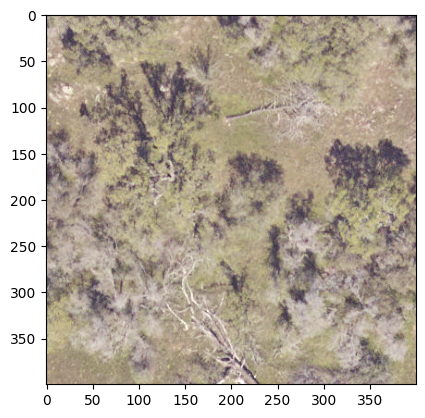

In [261]:
# Display image and label.
train_features= next(iter(neontree_dataloader))
print(f"Feature batch shape: {train_features.size()}")
img = train_features[0].squeeze()
plt.imshow(img, cmap="gray")
plt.show()
# print(f"Label: xmin={xmin.item()}, ymin={ymin.item()}, xmax={xmax.item()}, ymax={ymax.item()}")

### Inference

Single inference

Reading config file: /Users/julianzabbarov/Software/miniconda3/envs/aavsd/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


No validation file provided. Turning off validation loop
Model from DeepForest release https://github.com/weecology/DeepForest/releases/tag/1.0.0 was already downloaded. Loading model from file.
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


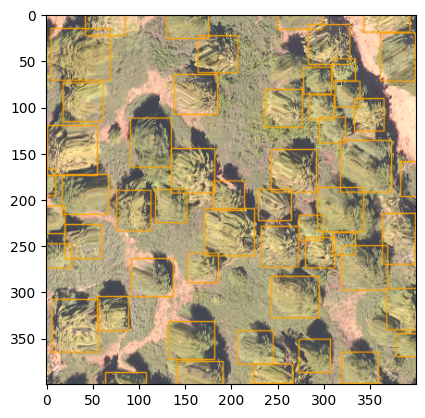

In [262]:
model = main.deepforest()
model.use_release()

sample_image_path = get_data("OSBS_029.png")

img = model.predict_image(image=neontree.__getitem__(193).astype(np.float32), return_plot=True)

#predict_image returns plot in BlueGreenRed (opencv style), but matplotlib likes RedGreenBlue, switch the channel order. Many functions in deepforest will automatically perform this flip for you and give a warning.
plt.imshow(img[:,:,::-1])

Inference for all images in benchmark

In [263]:
model = main.deepforest()
model.use_release()

sample_image_path = get_data("OSBS_029.png")

predictions = pd.DataFrame()

print("Predictions are running ...")
for img_idx in tqdm(range(len(neontree))):
    pred = model.predict_image(image=neontree.__getitem__(img_idx).astype(np.float32), return_plot=False)
    # append pred to predictions with value for image_path set to neontree.get_name(img_idx)
    pred["image_path"] = neontree.__getname__(img_idx)
    predictions = pd.concat([predictions, pred])

# pred = model.predict_image(image=neontree.__getitem__(200).astype(np.float32), return_plot=False)

Reading config file: /Users/julianzabbarov/Software/miniconda3/envs/aavsd/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


No validation file provided. Turning off validation loop
Model from DeepForest release https://github.com/weecology/DeepForest/releases/tag/1.0.0 was already downloaded. Loading model from file.
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0
Predictions are running ...


100%|██████████| 194/194 [01:32<00:00,  2.11it/s]


In [264]:
len(predictions)

6614

In [265]:
len(predictions["image_path"].unique())

194

In [268]:
# reorder columns
predictions = predictions[["image_path", "xmin", "ymin", "xmax", "ymax", "label", "score"]]
# sort by image_path
predictions.sort_values(by="image_path", inplace=True)
# remove .tif from image_path
predictions["image_path"] = predictions["image_path"].str.replace(".tif", "")
# reset index
predictions.reset_index(drop=True, inplace=True)
predictions.head(20)

,image_path,xmin,ymin,xmax,ymax,label,score
0,2018_SJER_3_252000_4104000_image_628,31.0,0.0,100.0,32.0,Tree,0.147352
1,2018_SJER_3_252000_4104000_image_628,315.0,2.0,382.0,77.0,Tree,0.325908
2,2018_SJER_3_252000_4104000_image_628,150.0,70.0,201.0,126.0,Tree,0.721416
3,2018_SJER_3_252000_4104000_image_628,224.0,53.0,249.0,85.0,Tree,0.446595
4,2018_SJER_3_252000_4104000_image_628,271.0,158.0,340.0,230.0,Tree,0.436136
5,2018_SJER_3_252000_4104000_image_628,359.0,210.0,400.0,299.0,Tree,0.398186
6,2018_SJER_3_252000_4104000_image_628,170.0,6.0,203.0,39.0,Tree,0.297405
7,2018_SJER_3_252000_4104000_image_628,210.0,0.0,249.0,13.0,Tree,0.145962
8,2018_SJER_3_252000_4106000_image_234,301.0,0.0,341.0,8.0,Tree,0.152291
9,2018_SJER_3_252000_4106000_image_234,337.0,0.0,381.0,5.0,Tree,0.167425


In [267]:
# export predictions to csv
predictions.to_csv(os.path.join(EXPORT_PRED_PATH, "benchmark_predictions.csv"), index=False)